# **Nadgledano učenje - Klasifikacija kvaliteta belog vina**
**Studenti**: 
 - Natalija Stamenković, 1258
 - Milica Todorović, 1256

**Tema**: Određivanje kvaliteta belog vina na osnovu fizičko-hemijskih karakteristika. Korišćeni skup podataka može se naći na linku: https://archive.ics.uci.edu/ml/datasets/wine+quality.


### ***Deskriptivna analiza podataka***
#### *Importovanje paketa*

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
%matplotlib inline

#### *Učitavanje skupa podataka*
U tabeli se mogu videti vrednosti atributa datog skupa podataka. Svi atributi su numeričkog kontinualnog tipa. Klasifikaciju je potrebno izvršiti na osnovu poslednje kolone (quality), pri čemu se vrednosti zavisna promenljiva uzima celobrojne vrednosti iz [1,9].

In [52]:
data = pd.read_csv("./dataset/winequality-white.csv", delimiter=';')
data.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


#### *Deskripcija atributa*
Sledeća tabela prikazuje statistične informacije o atributima.

In [53]:
print("Describe data:")
data.describe(include='all')

Describe data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [54]:
print("Median:")
data.median()

Median:


fixed acidity             6.80000
volatile acidity          0.26000
citric acid               0.32000
residual sugar            5.20000
chlorides                 0.04300
free sulfur dioxide      34.00000
total sulfur dioxide    134.00000
density                   0.99374
pH                        3.18000
sulphates                 0.47000
alcohol                  10.40000
quality                   6.00000
dtype: float64

#### *Provera nedefinisanih vrednosti*
Vrši se provera da li postoje atributi koji sadrže određeni missing vrednosti (vrednosti koje fale). Pokazuje se da podaci ne sadrže nedefinisane vrednosti.

In [55]:
def check_missing_vals(data):
    missing_vals = data.isna().sum()
    print(missing_vals)
    return missing_vals.sum() != 0

print("Missing values?:", check_missing_vals(data))

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Missing values?: False


#### *Histogram quality atributa*
Na sledećem grafiku prikazan je histogram atributa kvaliteta vina. Može se videti izrazita nebalansiranost među klasama kvaliteta.

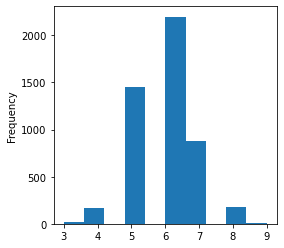

In [56]:
def plot_histogram(data, data_column):
    data[data_column].plot(kind='hist', figsize=(4, 4))
    
plot_histogram(data=data, data_column='quality')

#### *Boxplot atributa*
Sledeći grafik prikazuje boxplot vrednosti svakog od atributa, odnosno raspodelu vrednosti na 4 kvadranta. Može se uočiti veliki broj outlier-a u vrednostima atributa *free sulfur dioxide*, *total sulfur dioxide*, *residual sugar*, *alcohol*, *sulphates*, *pH*.

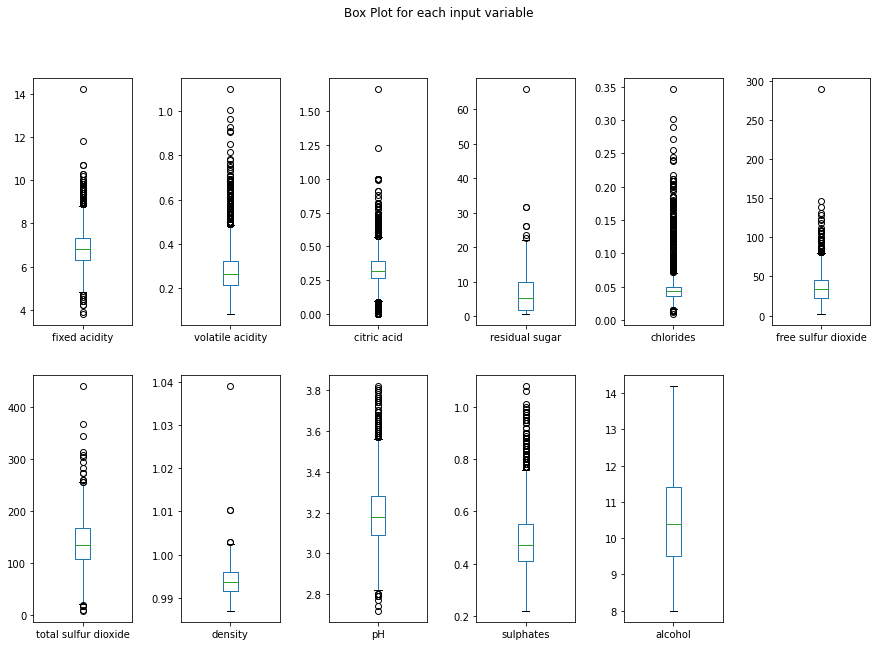

In [57]:
def plot_boxplot(data):
    data.drop('quality', axis=1).plot(kind='box', figsize=(15, 10), subplots=True, layout=(2, 6),
                                      sharex=False, sharey=False,
                                      title='Box Plot for each input variable')
    plt.subplots_adjust(wspace=0.5)
    
plot_boxplot(data)

#### *Raspodela vrednosti atributa po klasama*
Može se vizualizovati raspodela vrednosti atributa po klasama. Može se primetiti da određenih atributima vrednosti ne variraju u odnosnu na klasu kvaliteta, te je verovatno moguće date atribute isključiti iz dalje analize.

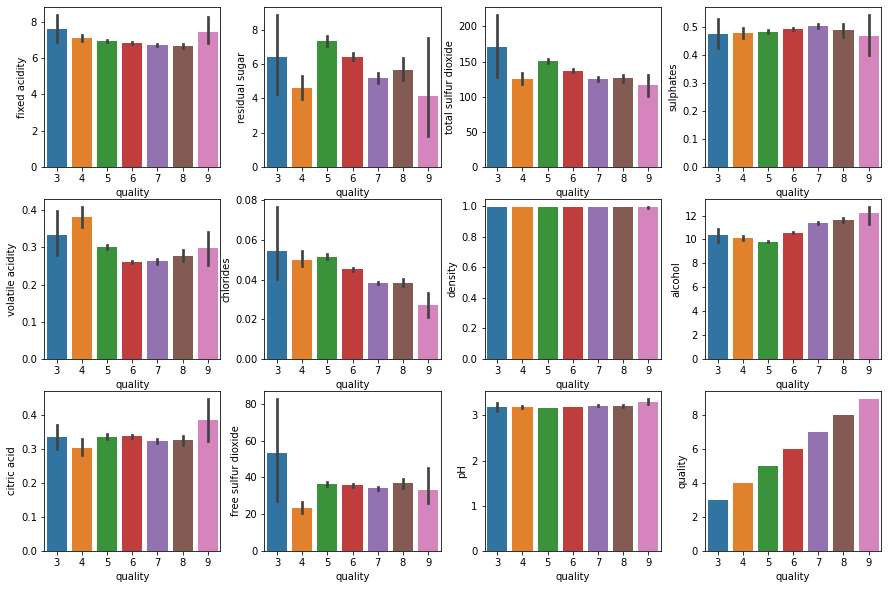

In [58]:
def plot_barplots(data):
    num_rows = 3
    num_cols = 4
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(0, num_rows):
        for j in range(0, num_cols):
            index = j * num_rows + i
            col_name = data.columns[index]
            sns.barplot(x='quality', y=col_name, data=data, ax=axs[i][j])
            
    plt.subplots_adjust(wspace=.25)

plot_barplots(data)

#### *Matrica korelacije*
Dijagram prikazuje matricu korelacije fičera. Takođe, se štampaju fičeri sortirani po koeficijentu korelacije u opadajućem poredku, u odnosu na zavisnu klasifikacionu promenljivu.
Može se uočiti da atribut *alcohol* ima najveći stepen korelacije sa atributom *quality*. Takođe, mogu se uočiti međusobne korelacije između atributa (atribut *density* je visoko korelisan sa većim brojem atributa).

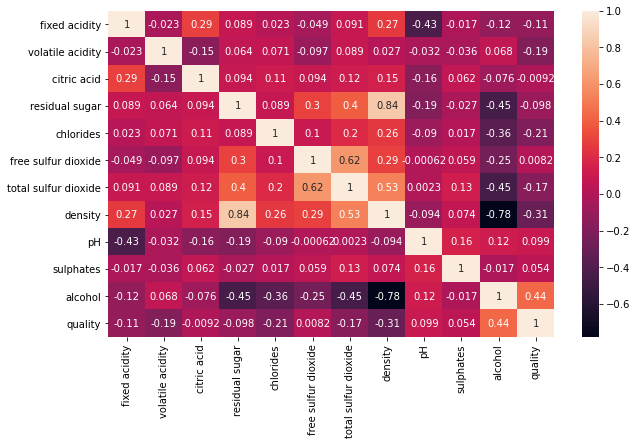

Sorted correlation values: 
 quality                 1.000000
alcohol                 0.435575
density                 0.307123
chlorides               0.209934
volatile acidity        0.194723
total sulfur dioxide    0.174737
fixed acidity           0.113663
pH                      0.099427
residual sugar          0.097577
sulphates               0.053678
citric acid             0.009209
free sulfur dioxide     0.008158
Name: quality, dtype: float64


In [59]:
def correlation_matrix(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
    plt.show()

    corr = abs(corr['quality']).sort_values(ascending=False)
    return corr

corr = correlation_matrix(data)
print("Sorted correlation values: \n", corr)

### *Predefinisanje klasa*
Kao što je prethodno pokazano atribut *quality* je izuzetno nebalansiran, te je pokušano predefinisanje klasa kako bi se nebalansiranost ublažila. Kvalitet vina podeljen je u 3 nove klase:
- bad: [1, 3]
- good: [4, 6]
- excellent: [7, 10].

Skup podataka je još uvek nebalansiran, ali je nebalansiranost ublažena.

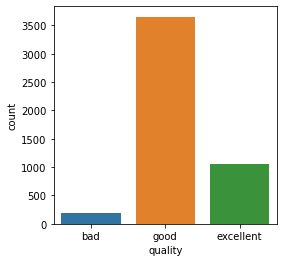

In [60]:
def redefine_classes(data):
    bins = (0, 4, 6, 10)
    labels = ['bad', 'good', 'excellent']
    redef_data = data.copy(deep=True)
    redef_data['quality'] = pd.cut(data['quality'], bins=bins, labels=labels)
    return redef_data

def plot_count(data, data_column):
    plt.figure(figsize=(4, 4))
    sns.countplot(x=data_column, data=data)

plot_count(redefine_classes(data), 'quality')

### ***Preprocesiranje podataka***
Preprocesiranje podataka uključuje prethodno opisano predefinisanje klasa. Kako je sada atribut *quality* kategoričkog tipa, potrebno je izvršiti enkodiranje datih klasa u numerični tip. Ovo se postiže korišćenjem LabelEncode-era.

In [61]:
def encode_labels(data):
    encode_quality = LabelEncoder()
    data['quality'] = encode_quality.fit_transform(data['quality'])
    return data

Dalje, potrebno je podeliti dati skup podataka na nezavisne promenljive (atribute - x) i zavisnu promenljivu (*quality* - y). Poslednja kolona predstavlja zavisnu promenljivu, dok ostale kolone predstavljaju fičere.

In [62]:
def extract_data(data):
    x = data.iloc[:, :-1].values
    # dependent variable
    y = data.iloc[:, -1].values
    return x, y

Nakon toga, vrši se podela skupa podataka na trening i test skupove, pri čemu je za trening skup uzeto 20% celokupnog skupa.

In [63]:
def split_dataset(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

Finalno, vrši se skaliranje vrednosti korišćenjem StandardScaler-a. Skaliranje se vrši zasebno na trening i test skupovima podataka, s obzirom da je potrebno tretirani test skup podataka kao podatke koji nisu prethodno "viđeni".

In [64]:
def scale_features(x_train, x_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    return x_train, x_test

Celokupno preprocesiranje:

In [65]:
data = redefine_classes(data)
data = encode_labels(data)

x, y = extract_data(data)
x_train, x_test, y_train, y_test = split_dataset(x, y)

x_train, x_test = scale_features(x_train, x_test)

In [66]:
df_train = pd.DataFrame(x_train)
df_train['quality'] = y_train
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,quality
0,0.515119,-1.076233,0.227731,0.340419,-0.813688,0.534065,-0.641932,-0.447041,-0.328261,-0.702445,1.540371,2
1,-0.669188,-0.288777,0.895832,1.002071,-0.217212,0.773947,1.355106,0.903370,-0.061886,0.266074,-0.821712,2


### ***Klasifikatori***

U nastavku su date pomoćne funkcije koje se koriste pri evaluaciji svakog modela/klasifikatora, određivanje matrice konfuzije i skora unakrsne validacije.

In [67]:
def confusion_matrix(y_test, y_pred, plot=False):
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", conf_matrix)

    if plot:
#         class_names = data['quality'].unique()
        df_conf = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
        sns.heatmap(df_conf, annot=True, fmt='g')
        plt.title("Confusion matrix:")
        plt.xlabel("False")
        plt.ylabel("True")
        

def cross_val_eval(estimator, x_train, y_train):
    cv_eval = cross_val_score(estimator=estimator, X=x_train, y=y_train, cv=5, scoring="accuracy")
    print("Cross validation - Accuracy:\n", cv_eval.mean())

In [68]:
# function for evaluating a model
def evaluate_model(estimator, x_train, y_train, y_test, y_pred, plot_conf=False):
    cross_val_eval(estimator, x_train, y_train)
    print("Accuracy:\n", metrics.accuracy_score(y_test, y_pred))
    print("Report:\n", metrics.classification_report(y_test, y_pred))
    confusion_matrix(y_test, y_pred, plot_conf)

In [69]:
# names of quality classes
class_names = [0, 1, 2]

Odabir najboljih hiperparametara klasifikatora vrši se korišćenjem GridSearchCV objekta.

In [70]:
# metod used to search for best hiperparameters for a given classifier
def grid_search(classifier, param_dict,
               x_train, y_train):
    gs = GridSearchCV(estimator=classifier, param_grid=param_dict, scoring="accuracy",
                          refit=True, cv=5, verbose=True, n_jobs=-1)
    gs.fit(x_train, y_train)

    print("Best estimator:\n", gs.best_params_)
    print("Best score: ", gs.best_score_)

    return gs.best_estimator_

Pokretanje klasifikatora sa opcionim korišćenjem pretrage hiperparametara.

In [71]:
def run_clf(clf, param_dict,
            x_train, x_test, y_train, y_test, plot_conf=False,
            is_grid_search=False):
    
    if is_grid_search:
        clf = grid_search(clf, param_dict,
                         x_train, y_train)
    else:
        # Train the algorithm
        clf.fit(x_train, y_train)
    
    # predict
    y_pred = clf.predict(x_test)
    #

    # evaluate
    evaluate_model(clf, x_train, y_train, y_test, y_pred, plot_conf)

#### *KNN*


In [72]:
# knn classifier
clf = KNeighborsClassifier()
# grid search params
param_dict = [{'n_neighbors': [3, 5, 11, 19, 23],
               'metric': ['euclidean', 'manhattan'],
               'weights': ['uniform', 'distance']}]

run_clf(clf, param_dict, x_train, x_test, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best score:  0.830524930278625
Cross validation - Accuracy:
 0.830524930278625
Accuracy:
 0.8316326530612245
Report:
               precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.77      0.56      0.65       227
           2       0.84      0.95      0.89       723

    accuracy                           0.83       980
   macro avg       0.87      0.51      0.54       980
weighted avg       0.83      0.83      0.81       980

Confusion matrix:
 [[  1   1  28]
 [  0 127 100]
 [  0  36 687]]


#### *SVM*

In [73]:
# classifier
clf = svm.SVC()
param_dict = [{'kernel': ['rbf'],
               'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]}]
# run classifier
run_clf(clf, param_dict, x_train, x_test, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best estimator:
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best score:  0.7812654755388746
Cross validation - Accuracy:
 0.7812654755388746
Accuracy:
 0.7765306122448979
Report:
               precision    recall  f1-score   support

           0       0.50      0.03      0.06        30
           1       0.70      0.29      0.41       227
           2       0.79      0.96      0.86       723

    accuracy                           0.78       980
   macro avg       0.66      0.43      0.45       980
weighted avg       0.76      0.78      0.73       980

Confusion matrix:
 [[  1   0  29]
 [  0  66 161]
 [  1  28 694]]


#### *Random Forest*
Prvi posmatrani klasifikator je Random Forest klasifikator.

In [74]:
# random forest classifier
clf = RandomForestClassifier()
# grid search params
param_dict = {
    "n_estimators": [50, 100, 150, 200, 250],
    "min_samples_leaf": range(1, 5),
    "criterion": ['gini', 'entropy'],
    "class_weight": ["balanced", None, "balanced_subsample"]
}

run_clf(clf, param_dict, x_train, x_test, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best estimator:
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100}
Best score:  0.8369047619047618
Cross validation - Accuracy:
 0.8328198712435165
Accuracy:
 0.8428571428571429
Report:
               precision    recall  f1-score   support

           0       0.75      0.10      0.18        30
           1       0.82      0.57      0.67       227
           2       0.85      0.96      0.90       723

    accuracy                           0.84       980
   macro avg       0.81      0.54      0.58       980
weighted avg       0.84      0.84      0.83       980

Confusion matrix:
 [[  3   0  27]
 [  0 130  97]
 [  1  29 693]]


In [76]:
#### *Gradient boost*

In [75]:
# classifier
clf = GradientBoostingClassifier()
param_dict = {
    "n_estimators": [50, 100, 150, 200, 250],
    "criterion": ["friedman_mse", "mse"],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "max_depth": range(3, 6)
}


run_clf(clf, param_dict, x_train, x_test, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best estimator:
 {'criterion': 'mse', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 250}
Best score:  0.828992037427998
Cross validation - Accuracy:
 0.8261849375765632
Accuracy:
 0.8306122448979592
Report:
               precision    recall  f1-score   support

           0       0.52      0.37      0.43        30
           1       0.75      0.60      0.67       227
           2       0.86      0.92      0.89       723

    accuracy                           0.83       980
   macro avg       0.71      0.63      0.66       980
weighted avg       0.82      0.83      0.82       980

Confusion matrix:
 [[ 11   0  19]
 [  0 136  91]
 [ 10  46 667]]


### ***Balansiranje podataka i izbacivanje outlier-a***
Prethodno je pokazano da prikazani klasifikatori ne daju previše loše rezultate. Međutim, matrica konfuzije, kao i pojedinačni f1-score za svaku klasu pokazuju da se svi klasifikatori ponašaju relativno loše kada su u pitanju nulta i prva klasa. 